# SRGAN

In [47]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch
import os
from math import log2
import torch.utils.data
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn import functional as F
import numpy as np
from torchvision.utils import save_image
%matplotlib inline
from torchvision.models.vgg import vgg16

def get_device(gpu_id=-1):
    if gpu_id >= 0 and torch.cuda.is_available():
        return torch.device("cuda", gpu_id)
    else:
        return torch.device("cpu")
device = get_device(gpu_id=0)
print(device)

cuda:0


In [17]:
if not os.path.exists("./traindata/lr-sr"):
    os.mkdir("./traindata/lr-sr")
    
if not os.path.exists("./traindata/lr-sr/save_image"):
    os.mkdir("./traindata/lr-sr/save_image")
    
if not os.path.exists("./traindata/lr-sr/dataset"):
    os.mkdir("./traindata/lr-sr/dataset")
if not os.path.exists("./traindata/lr-sr/dataset/train"):
    os.mkdir("./traindata/lr-sr/dataset/train")
if not os.path.exists("./traindata/lr-sr/dataset/test"):
    os.mkdir("./traindata/lr-sr/dataset/test")
    
if not os.path.exists("./traindata/lr-sr/asset"):
    os.mkdir("./traindata/lr-sr/asset")
    
    
# data_dir = "../Datasets/DCGAN_data/natural_images/person/"
# for i in range(100,900):
#     name = "person_0"+str(i)
#     path = data_dir+name+".jpg"
#     img = cv2.imread(path,cv2.COLOR_RGB2BGR)
#     folder = "./traindata/lr-sr/dataset/"+name
#     if not os.path.exists(folder):
#         os.mkdir(folder)
#     cv2.imwrite(folder+"/"+name+".jpg",img)

In [23]:
class DownSizePairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, large_size=256, small_size=64, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)
        
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
        return small_img, large_img

In [25]:
train_data = DownSizePairImageFolder("./traindata/lr-sr/dataset/", transform=transforms.ToTensor())
batch_size = 1
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4)

torch.Size([3, 256, 256])
0.96862745 0.0


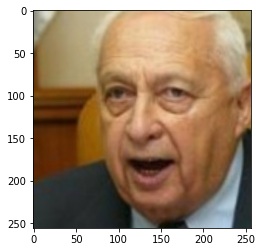

In [26]:
images_lr, images_hr = iter(train_loader).next()
image=images_hr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

torch.Size([3, 64, 64])
0.95686275 0.0


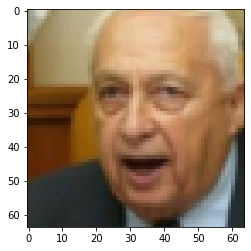

In [27]:
image=images_lr[0]
print(image.size())
image_np=image.numpy()
print(image_np.max(),image_np.min())
image_np=np.transpose(image_np,(1,2,0))
plt.imshow(image_np)

In [50]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
ngpu = 1

# Generator
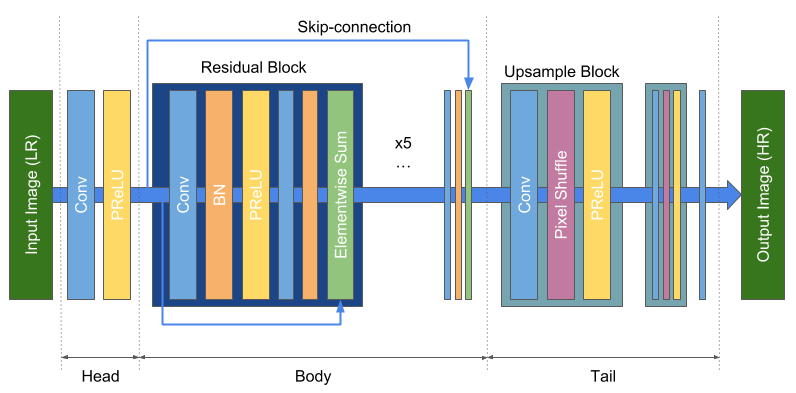

In [51]:
class Generator(nn.Module):
    def __init__(self, ngpu, scale_factor=4):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.head = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.body = nn.Sequential(
            *[ResidualBlock(64) for _ in range(16)],
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.PReLU()
        )
        self.tail = nn.Sequential(
            *[UpsampleBLock(64, 2) for _ in range(int(log2(scale_factor)))],
            nn.Conv2d(64, 3, kernel_size=9, padding=4),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.head(x)
        x = self.body(x) + x
        x = self.tail(x)
        return (x + 1) / 2
    
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
        )
    def forward(self, x):
        return self.net(x) + x

class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, upscale_factor):
        super(UpsampleBLock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, in_channels *
                      (upscale_factor ** 2), kernel_size=3, padding=1),
            nn.PixelShuffle(upscale_factor),
            nn.PReLU()
        )
    def forward(self, x):
        return self.net(x)

In [52]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

Generator(
  (head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (body): Sequential(
    (0): ResidualBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (net): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): PReLU(num_parameters=1)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1,

# Discriminator
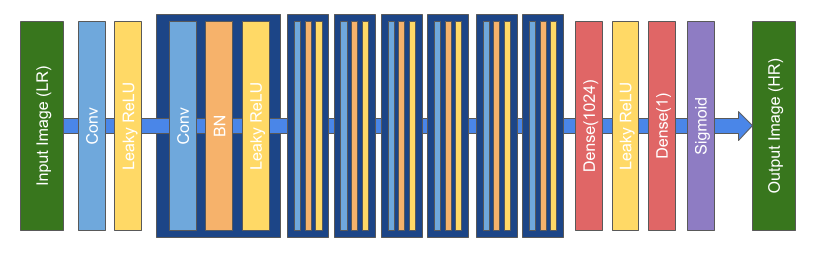

In [64]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, patch_size=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            Flatten(),
            nn.Linear(512 * (patch_size // 2 ** 4) ** 2, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [65]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(256, 256, 

# loss & optimizer

In [66]:
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, d_out_real, d_out_fake):
        loss_real = self.bce_loss(d_out_real, torch.ones_like(d_out_real))
        loss_fake = self.bce_loss(d_out_fake, torch.zeros_like(d_out_fake))
        return loss_real + loss_fake

In [67]:
class GeneratorLoss(nn.Module):
    def __init__(self, loss_type='vgg22', adv_coefficient=1e-3):
        super(GeneratorLoss, self).__init__()
        self.content_loss = VGGLoss(loss_type)
        self.mse_loss = nn.MSELoss()
        self.adv_coefficient = adv_coefficient

    def forward(self, d_out_fake, real_img, fake_img):
        mse_loss = self.mse_loss(real_img, fake_img)
        content_loss = self.content_loss(real_img, fake_img)
        adv_loss = torch.mean(-torch.log(d_out_fake + 1e-3))
        return mse_loss + 2e-6 * content_loss + self.adv_coefficient * adv_loss

In [68]:
print('===> Defining criterions')
mse_loss = nn.MSELoss().to(device)
criterionG = GeneratorLoss(loss_type="vgg22", adv_coefficient=1e-3).to(device)
criterionD = DiscriminatorLoss().to(device)

print('===> Defining optimizers')
optimizerG = optim.Adam(netG.parameters(), lr=1e-4)
optimizerD = optim.Adam(netD.parameters(), lr=1e-4)

===> Defining criterions
===> Defining optimizers


In [69]:
from torchvision.models.vgg import vgg19

class VGGLoss(nn.Module):
    def __init__(self, loss_type):
        super(VGGLoss, self).__init__()
        vgg = vgg19(pretrained=True)
        if loss_type == 'vgg22':
            vgg_net = nn.Sequential(*list(vgg.features[:9]))
        elif loss_type == 'vgg54':
            vgg_net = nn.Sequential(*list(vgg.features[:36]))
        
        for param in vgg_net.parameters():
            param.requires_grad = False

        self.vgg_net = vgg_net.eval()
        self.mse_loss = nn.MSELoss()

        self.register_buffer('vgg_mean', torch.tensor([0.485, 0.456, 0.406], requires_grad=False))
        self.register_buffer('vgg_std', torch.tensor([0.229, 0.224, 0.225], requires_grad=False))

    def forward(self, real_img, fake_img):
        real_img = real_img.sub(self.vgg_mean[:, None, None]).div(self.vgg_std[:, None, None])
        fake_img = fake_img.sub(self.vgg_mean[:, None, None]).div(self.vgg_std[:, None, None])
        feature_real = self.vgg_net(real_img)
        feature_fake = self.vgg_net(fake_img)
        return self.mse_loss(feature_real, feature_fake)

# Training

In [70]:
for iteration, (input_img, real_img) in enumerate(train_loader, 1):
    input_img = input_img.to(device)
    real_img = real_img.to(device)
    fake_img = netG(input_img)

    # Update D
    optimizerD.zero_grad()
    d_out_real = netD(real_img)
    d_out_fake = netD(fake_img)
    d_loss = criterionD(d_out_real, d_out_fake)
    d_loss.backward(retain_graph=True)
    optimizerD.step()

    # Update G
    optimizerG.zero_grad()
    g_loss = criterionG(d_out_fake, real_img, fake_img)
    g_loss.backward()
    optimizerG.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x131072 and 8192x1024)